In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns


Input shape:torch.Size([32, 100, 512])
Output shape:torch.Size([32, 100, 512])


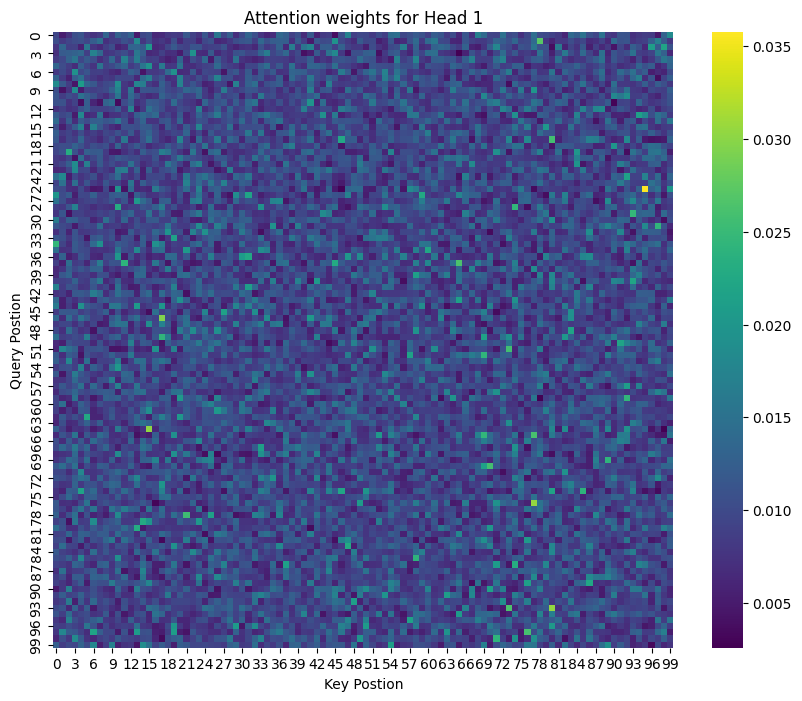

In [3]:
class MultiQueryAttention(nn.Module):
  def __init__(self,d_model,num_heads,dropout=0.1):
    super().__init__()
    self.d_model=d_model
    self.num_heads=num_heads
    self.head_dim=d_model//num_heads

    self.q_proj=nn.Linear(d_model,d_model)
    self.kv_proj=nn.Linear(d_model,2*d_model)
    self.out_proj=nn.Linear(d_model,d_model)

    self.dropout=nn.Dropout(dropout)
  def forward(self,q,kv,mask=None):
    batch_size=q.size(0)

    q=self.q_proj(q).view(batch_size,-1,self.num_heads,self.head_dim).transpose(1,2)
    k,v=self.kv_proj(kv).chunk(2,dim=-1)
    k=k.reshape(batch_size,-1,1,self.head_dim).expand(-1,-1,self.num_heads,-1 ).transpose(1,2)
    v=v.reshape(batch_size,-1,1,self.head_dim).expand(-1,-1,self.num_heads,-1).transpose(1,2)
    attn_scores=torch.matmul(q,k.transpose(-2,-1))/(self.head_dim**0.5)

    if mask is not None:
      attn_scores=attn_scores.masked_fill(mask==0,float('-inf'))
    attn_probs=self.dropout(torch.softmax(attn_scores,dim=-1))

    out=torch.matmul(attn_probs,v).transpose(1,2).contiguous().view(batch_size,-1,self.d_model)
    return self.out_proj(out)


  def visualize_attention(self,attn_weights,head_idx=0):
    fig,ax=plt.subplots(figsize=(10,8))
    sns.heatmap(attn_weights[0,head_idx].detach().cpu().numpy(),ax=ax,cmap='viridis')
    ax.set_title(f"Attention weights for Head {head_idx+1}")
    ax.set_xlabel("Key Postion")
    ax.set_ylabel("Query Postion")
    plt.show()

if __name__=="__main__":
  d_model=512
  num_heads=8
  mqa=MultiQueryAttention(d_model,num_heads)

  seq_len=100
  x=torch.randn(32,seq_len,d_model)
  output=mqa(x,x)


  print(f"Input shape:{x.shape}")
  print(f"Output shape:{output.shape}")


  with torch.no_grad():
    q=mqa.q_proj(x).view(32,seq_len,num_heads,-1).transpose(1,2)
    k,_=mqa.kv_proj(x).chunk(2,dim=-1)
    k=k.view(32,seq_len,num_heads,-1).transpose(1,2)

    attn_weights=torch.softmax(torch.matmul(q,k.transpose(-2,-1))/(mqa.head_dim**0.5),dim=-1)
    mqa.visualize_attention(attn_weights)